In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "CRPS"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'DGBT', 'DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_CRPS': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

df = df[df["metric"] == "CRPS"]
df = df[df["split_method"] == "random_split"]


=== RAW normalized_accuracy sample ===
     split_method  task_id                  model      value  baseline  \
556  random_split   361093                    DRF   0.248467  0.023953   
557  random_split   361093                   DGBT   0.025728  0.023953   
565  random_split   361093        LinearRegressor   0.232171  0.023953   
567  random_split   361093      ConstantPredictor   0.302430  0.023953   
580  random_split   361093           GPBoost_CRPS   0.028158  0.023953   
589  random_split   361093             Engression   0.064408  0.023953   
591  random_split   361093                    MLP   0.037712  0.023953   
593  random_split   361093                 ResNet   0.034384  0.023953   
595  random_split   361093          FTTransformer   0.026928  0.023953   
621  random_split   361093        TabPFNRegressor   0.025239  0.023953   
629  random_split   361093  RandomForestRegressor   0.027863  0.023953   
631  random_split   361093          LGBMRegressor   0.023953  0.023953  

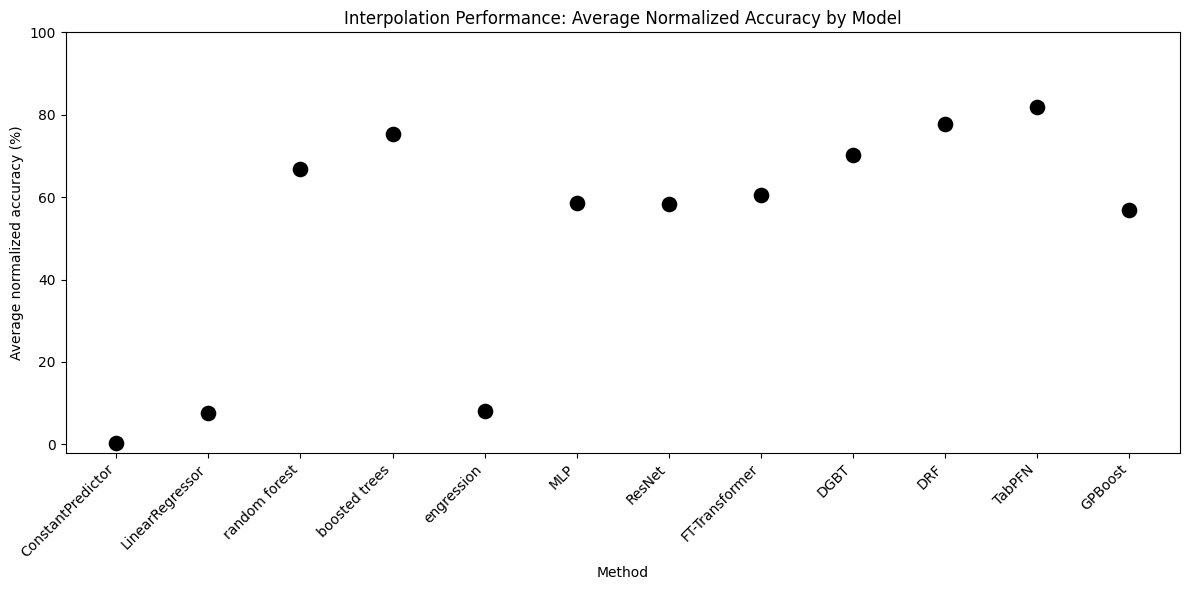

In [3]:
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LinearRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','DGBT','DRF', 'TabPFNRegressor', 'GPBoost_CRPS'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN',
    'GPBoost_CRPS':        'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=overall,
    x='Method',
    y='Mean',
    color='black',
    s=150
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average normalized accuracy (%)')
plt.xlabel('Method')
plt.title('Interpolation Performance: Average Normalized Accuracy by Model')
plt.ylim(-2, 100)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
fname = f"PICTURES/avg_normalized_acc_over_interpolation_{metric}.png"
plt.savefig(
    fname,
    bbox_inches='tight'
)
plt.show()
